#Crate and Barrel Project

####For this project we are provided a dataset with 93 features for more than 200,000 products. The objective is to build a predictive model which is able to distinguish between our main product categories

######Our data fields are:
* id - an anonymous id unique to a product
* feat_1, feat_2, ..., feat_93 - the various features of a product
* target - the class of a product

#####We must submit a csv file with the product id, all candidate class names, and a probability for each class. The order of the rows does not matter. The file must have a header.

In [1]:
#Import libraries
import pandas as pd
import numpy as np

In [2]:
#Import dataset
data = pd.read_csv('train.csv')
data

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61873,61874,1,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,2,0,Class_9
61874,61875,4,0,0,0,0,0,0,0,0,...,0,2,0,0,2,0,0,1,0,Class_9
61875,61876,0,0,0,0,0,0,0,3,1,...,0,3,1,0,0,0,0,0,0,Class_9
61876,61877,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,3,10,0,Class_9


In [3]:
#Separate data into features and labels
features = data.drop(['target', 'id'], axis='columns')
labels = data['target']
labels

0        Class_1
1        Class_1
2        Class_1
3        Class_1
4        Class_1
          ...   
61873    Class_9
61874    Class_9
61875    Class_9
61876    Class_9
61877    Class_9
Name: target, Length: 61878, dtype: object

##Using XGBoost Classifier

Because the label values in the `target` column are strings, we must use sklearn's label encoder to get the values to be integers starting at 0 to use them with XGBoost.




In [4]:
#Label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)
labels

array([0, 0, 0, ..., 8, 8, 8])

In [5]:
#Split into test and train groups
from sklearn.model_selection import train_test_split
features_train,features_test,labels_train,labels_test = train_test_split(features,labels,test_size=0.2)

In [6]:
#Create XGBoost classifier
from xgboost import XGBClassifier
params = { "n_estimators": 100, 'tree_method':'gpu_hist', 'predictor':'gpu_predictor' }
model = XGBClassifier(**params)
#Fit the model
model.fit(features_train, labels_train)
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor='gpu_predictor', ...)

In [7]:
#Evaluate the model and get accuracy
from sklearn.metrics import accuracy_score
predictions = model.predict(features_test)
accuracy_score(labels_test, predictions)

0.8112475759534583

####So with our first classifier, XGBoost, we received 81% accuracy

We can use a parameter grid to try to find the best hyperparameters

In [8]:
param_grid = { 'n_estimators': [50, 100, 150, 200], 'max_depth':[2, 4, 6, 8] }

In [9]:
#Select 5 combinations of hyperparameters at random for the sake of time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
param_comb = 5
folds=5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=param_comb,  n_jobs=-1, 
                                   cv=skf.split(features_train,labels_train), verbose=3)

In [10]:
#Fit the model
grid_result = random_search.fit(features_train,labels_train)
#See the best hyperparameters
random_search.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'n_estimators': 150, 'max_depth': 8}

In [11]:
#Evaluate the model and get accuracy
predictions = random_search.best_estimator_.predict(features_test)
accuracy_score(labels_test, predictions)

0.8213477698771816

With an n_estimators value of 150 and a max_depth of 8, we were able to increase our accuracy form 81.1% to 82%

###In an attempt to increase accuracy, I will utilize a parameter grid again with larger n_estimators values for the number of classifiers

In [12]:
param_grid = { 'n_estimators': [200, 250, 300, 350], 'max_depth':[2, 4, 6, 8] }
#Select 5 combinations of hyperparameters at random for the sake of time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
param_comb = 5
folds=5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=param_comb,  n_jobs=-1, 
                                   cv=skf.split(features_train,labels_train), verbose=3)

In [13]:
#Fit the model
grid_result = random_search.fit(features_train,labels_train)
#See the best hyperparameters
random_search.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'n_estimators': 300, 'max_depth': 6}

In [14]:
#Evaluate the model and get accuracy
predictions = random_search.best_estimator_.predict(features_test)
accuracy_score(labels_test, predictions)

0.8239334195216548

With an n_estimators vale of 350 and max_depth of 8, the model had an 82.4% accuracy score.

###We can utilize k-fold cross validation to improve our XGBoost classifier

In [15]:
#Create XGBoost classifier
from xgboost import XGBClassifier
params = { 'max_depth':6, "n_estimators": 300, 'tree_method':'gpu_hist', 'predictor':'gpu_predictor' }
model = XGBClassifier(**params)

model.fit(features_train, labels_train)

#Cross-validation with 10 folds
from sklearn.model_selection import cross_val_score
acc_scores = cross_val_score(model, features, labels,
                         scoring="accuracy",
                         cv=10, n_jobs=-1)

print("Accuracy Values: ", np.round(acc_scores, 2))
print("Average Accuracy: ", np.mean(acc_scores))

Accuracy Values:  [0.82 0.82 0.82 0.82 0.82 0.82 0.83 0.84 0.83 0.82]
Average Accuracy:  0.8244933858960899


#####Attempting again with altered hyperparameters

In [16]:
#Create XGBoost classifier
from xgboost import XGBClassifier
params = { 'max_depth':7, "n_estimators": 250, 'tree_method':'gpu_hist', 'predictor':'gpu_predictor' }
model = XGBClassifier(**params)

model.fit(features_train, labels_train)

#Cross-validation with 10 folds
from sklearn.model_selection import cross_val_score
acc_scores = cross_val_score(model, features, labels,
                         scoring="accuracy",
                         cv=10, n_jobs=-1)

print("Accuracy Values: ", np.round(acc_scores, 2))
print("Average Accuracy: ", np.mean(acc_scores))

Accuracy Values:  [0.82 0.83 0.82 0.82 0.83 0.82 0.82 0.84 0.83 0.82]
Average Accuracy:  0.8259640263709516


####Using parameter grid with a combination of our best estimated hyperparameters from past parameter grids

In [18]:
param_grid = { 'n_estimators': [150, 250, 300, 400], 'max_depth':[6, 7, 8, 9] }
#Select 5 combinations of hyperparameters at random for the sake of time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
param_comb = 5
folds=5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=param_comb,  n_jobs=-1, 
                                   cv=skf.split(features_train,labels_train), verbose=3)

#Fit the model
grid_result = random_search.fit(features_train,labels_train)
#See the best hyperparameters
random_search.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'n_estimators': 400, 'max_depth': 7}

In [19]:
#Create XGBoost classifier
from xgboost import XGBClassifier
params = { 'max_depth':9, "n_estimators": 250, 'tree_method':'gpu_hist', 'predictor':'gpu_predictor' }
model = XGBClassifier(**params)

model.fit(features_train, labels_train)

#Cross-validation with 10 folds
from sklearn.model_selection import cross_val_score
acc_scores = cross_val_score(model, features, labels,
                         scoring="accuracy",
                         cv=10, n_jobs=-1)

print("Accuracy Values: ", np.round(acc_scores, 2))
print("Average Accuracy: ", np.mean(acc_scores))

Accuracy Values:  [0.82 0.82 0.83 0.83 0.82 0.83 0.83 0.83 0.83 0.83]
Average Accuracy:  0.8258024441639993


###The results of the parameter grid show that the best hyperparameters as those that were : 'n_estimators': 250, 'max_depth': 9 which gave us an accuracy of 82.6%

####We will now train on the entire training set

In [20]:
#Get datasets
data = pd.read_csv('train.csv')
features_data = data.drop(['target', 'id'], axis='columns')
labels_data = data['target']
test = pd.read_csv('test.csv')
test_data = test.drop('id', axis = 1)

#Label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_data = le.fit_transform(labels_data)

#Create XGBoost classifier
from xgboost import XGBClassifier
params = { 'max_depth':9, "n_estimators": 250, 'tree_method':'gpu_hist', 'predictor':'gpu_predictor' }
model = XGBClassifier(**params)

#Fit the model
model.fit(features_data, labels_data)

#Make predictions on the test dataset
predictions = model.predict_proba(test_data)

#Create submission CSV
results = pd.DataFrame(columns=['id'], data=test['id'])
results = pd.concat([results, pd.DataFrame(predictions, columns=['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Class_7', 'Class_8', 'Class_9'])], axis=1)
results.to_csv('CB_Submission.csv',index = False)

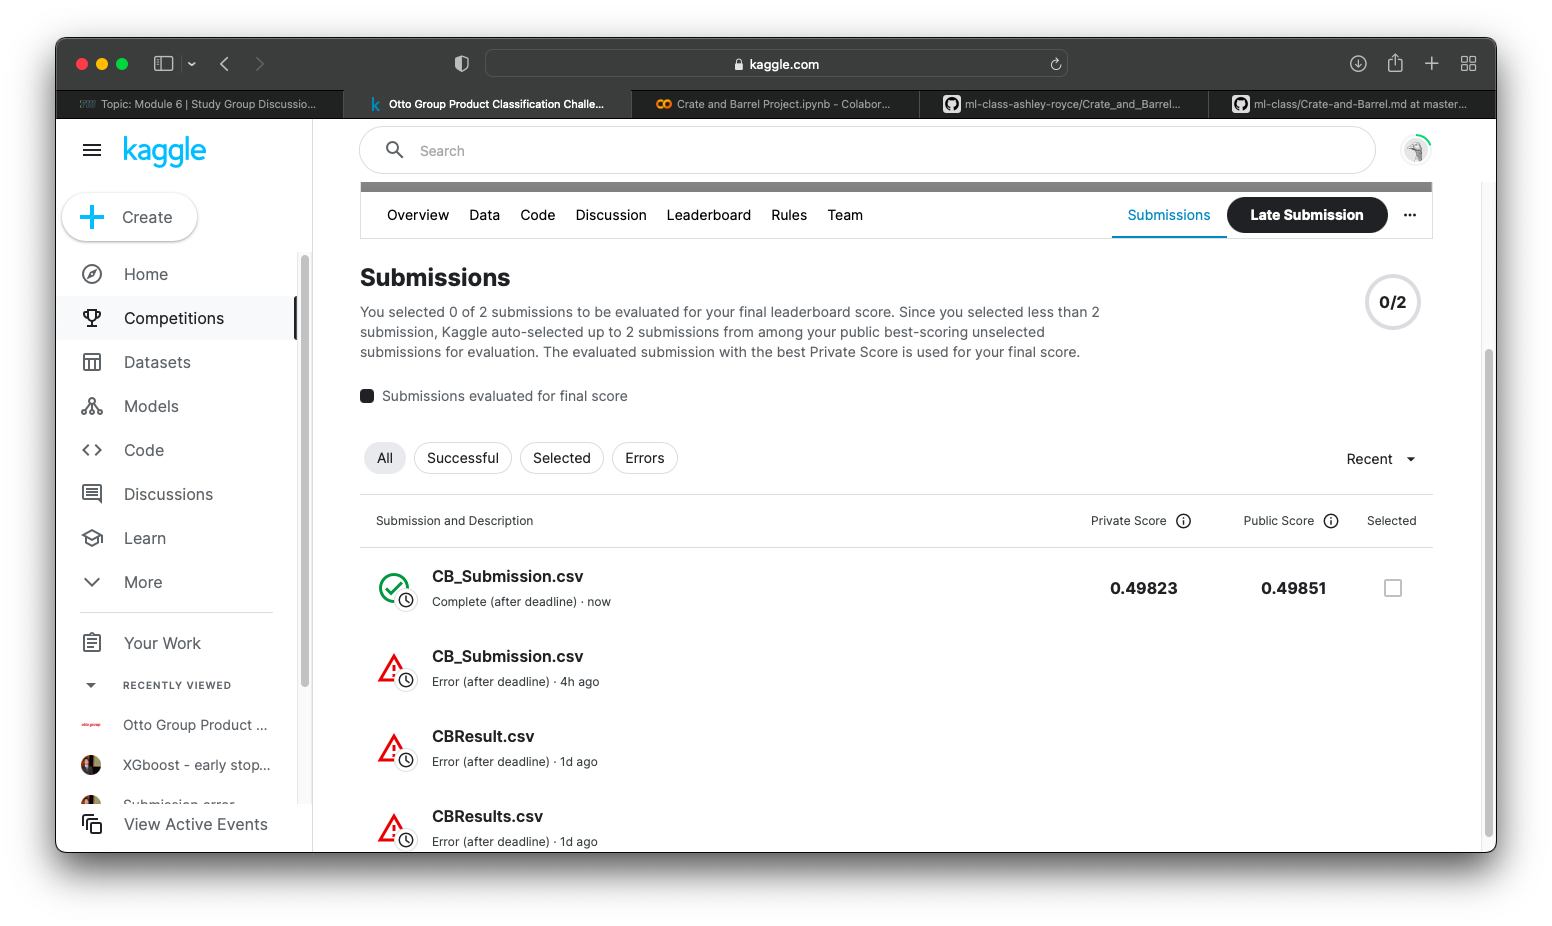